<a href="https://colab.research.google.com/github/jajapuramshivasai/Open_Project_Winter_2025/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1 Assignment: Quantum Measurement Dataset Foundations

Build a reproducible tomography workflow that scales from single qubit calibration studies to multi qubit benchmarks. Begin by setting up your environment locally (with OS-specific guidance) or in Google Colab, then generate measurement outcomes using Symmetric Informationally Complete POVMs (SIC POVMs) or Pauli projective measurements. Extend the pipeline with random circuits and document the trade offs you observe.

**Task roadmap**
1. Set up and document your environment.
2. Review the Born rule plus SIC POVM and Pauli projective measurement theory.
3. Generate and visualize QST datasets.
4. Perform single qubit tomography
5. Validate reconstructions, summarize findings, and package deliverables.

> Collaboration on planning is allowed, but every artifact you submit must be authored and executed by you.

## Task 1 · Environment Setup
**Choose one deployment path and capture the exact commands you run.**

### Local virtual environment (recommended)
- **macOS / Linux:**
  1. `python3 -m venv .venv`
  2. `source .venv/bin/activate`
  3. `python -m pip install --upgrade pip wheel`
- **Windows (PowerShell):**
  1. `py -3 -m venv .venv`
  2. `.venv\Scripts\Activate.ps1`
  3. `python -m pip install --upgrade pip wheel`

### Google Colab fallback
- Create a new notebook at https://colab.research.google.com and enable a GPU if available.
- Install the required libraries in the first cell (see the pip example below).
- Save the executed notebook to Drive and export a copy for submission evidence.

### Required baseline packages
- qiskit/pennylane (or an equivalent simulator such as cirq or qutip)
- numpy, scipy, pandas
- plotly (interactive visualization)
- tqdm (progress bars) plus any other support tooling you need


In [1]:
# Run inside your activated virtual environment or a Colab cell.
# Feel free to adjust versions based on your simulator choice.
!python -m pip install  pennylane numpy scipy pandas plotly tqdm nbformat



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


## Task 2 · Measurement Theory Primer
### Born rule recap
- For a state described by density matrix ρ and measurement operator M_k, the probability of outcome k is `p(k) = Tr(M_k ρ)`.
- For projective measurements, `M_k = P_k` with `P_k^2 = P_k` and `∑_k P_k = I`. For POVMs, `M_k = E_k` where each `E_k` is positive semi-definite and `∑_k E_k = I`.
- Document a short derivation or reference plus a numerical completeness check for your operators.

### SIC POVM vs. Pauli projective (single qubit)
- **SIC POVM strengths:** informational completeness with only four outcomes, symmetric structure, resilience to certain noise.
- **SIC POVM trade-offs:** hardware calibration overhead, non-standard measurement bases, denser classical post-processing.
- **Pauli projective strengths:** hardware-native eigenbases, easier interpretation, wide toolkit support.
- **Pauli projective trade-offs:** requires multiple bases (X/Y/Z) for completeness, higher shot budgets, basis-alignment sensitivity.

Use the `build_measurement_model` stub to serialize your chosen operators (matrices, normalization logs, metadata). Summarize the pros/cons in your notes and justify the model (or hybrid) you adopt for tomography.

### Reference single-qubit states
Prepare at minimum the computational basis (|0⟩, |1⟩), the Hadamard basis (|+⟩, |−⟩), and one phase-offset state (e.g., `( |0⟩ + i |1⟩ ) / √2`). Document how you synthesize each state in circuit form and store a textual or JSON summary of the gates used. You may optionally include mixed states by applying depolarizing or amplitude damping channels.

### Measurement Theory Primer

**1. Born Rule Recap**
The probability of obtaining a measurement outcome $k$ from a quantum state represented by the density matrix $\rho$ is given by the **Born Rule**:
$$p(k) = \text{Tr}(M_k \rho)$$
where $\{M_k\}$ is the set of measurement operators (POVM elements). For the probabilities to form a valid distribution, the operators must be positive semi-definite ($M_k \ge 0$) and sum to the identity ($\sum M_k = I$).

**2. Pauli Projective vs. SIC-POVM**
We considered two standard approaches for Single Qubit Tomography:

* **Pauli Projective Measurements (PVM):**
    * **Definitions:** Projections onto the eigenstates of the Pauli matrices ($Z, X, Y$).
    * **Set Size:** 6 operators total (2 per basis: $|0\rangle\langle0|, |1\rangle\langle1|, |+\rangle\langle+|, \dots$).
    * **Pros:** Standard on almost all quantum hardware; easy to implement via single-qubit rotations.
    * **Cons:** Requires changing measurement settings (3 separate bases). It is overcomplete (6 data points for 3 degrees of freedom).

* **Symmetric Informationally Complete POVM (SIC-POVM):**
    * **Definitions:** 4 operators forming a regular tetrahedron on the Bloch sphere.
    * **Set Size:** 4 operators (minimal sufficient set for $d=2$).
    * **Pros:** Requires no basis switching (in theory) and treats all directions symmetrically.
    * **Cons:** Harder to implement physically on standard hardware without ancilla qubits.

**3. Implementation & Validation**
In this notebook, we implemented the **Pauli Projective** model.
* **Operators:** We constructed projectors $P_{\pm} = \frac{1}{2}(I \pm \sigma)$ for $\sigma \in \{X, Y, Z\}$.
* **Validation:** The `build_measurement_model` function programmatically verifies completeness by ensuring that for each basis, the operators sum to the Identity matrix ($P_0 + P_1 = I$).

In [2]:
import numpy as np
import cmath
from typing import Dict, Any, List
import pathlib

def build_measurement_model(mode: str = "pauli") -> Dict[str, Any]:
    """
    Constructs measurement operators for single-qubit tomography.
    
    Args:
        mode: "pauli" for 6-outcome projective measurements (Z, X, Y bases)
              or "sic" for 4-outcome SIC-POVM.
    
    Returns:
        Dict containing operators, basis names, and validation metadata.
    """
    # Define standard basis states
    ket0 = np.array([[1], [0]], dtype=complex)
    ket1 = np.array([[0], [1]], dtype=complex)
    
    # Helper to create projector |psi><psi|
    def projector(ket):
        return ket @ ket.conj().T

    operators = {}
    
    if mode.lower() == "pauli":
        # 1. Pauli Projective Measurements (3 bases, 2 outcomes each = 6 operators)
        # Z-basis
        operators['Z0'] = projector(ket0)
        operators['Z1'] = projector(ket1)
        
        # X-basis: |+>, |->
        ket_plus = (ket0 + ket1) / np.sqrt(2)
        ket_minus = (ket0 - ket1) / np.sqrt(2)
        operators['X0'] = projector(ket_plus)
        operators['X1'] = projector(ket_minus)
        
        # Y-basis: |+i>, |-i>
        ket_i_plus = (ket0 + 1j*ket1) / np.sqrt(2)
        ket_i_minus = (ket0 - 1j*ket1) / np.sqrt(2)
        operators['Y0'] = projector(ket_i_plus)
        operators['Y1'] = projector(ket_i_minus)
        
        description = "Pauli Projective (6 outcomes: Z0, Z1, X0, X1, Y0, Y1)"

    elif mode.lower() == "sic":
        # 2. SIC POVM (4 outcomes, Symmetric Informationally Complete)
        # Vertices of a tetrahedron on the Bloch sphere.
        # We scale them by 1/2 so that sum(E_k) = I (since d=2).
        
        # Base vector (fiducial)
        operators = {}
        # Construction using standard tetrahedral vectors
        # v0 = |0>
        v0 = ket0
        E0 = 0.5 * projector(v0)
        
        # Other 3 vectors generated by rotating v0
        # This standard construction gives a regular simplex
        const_a = np.sqrt(1/3)
        const_b = np.sqrt(2/3)
        
        # Vectors unnormalized first
        vecs = [
            np.array([[1], [0]], dtype=complex),  # |0>
            np.array([[const_a], [const_b * cmath.exp(0j)]], dtype=complex), 
            np.array([[const_a], [const_b * cmath.exp(2j * np.pi / 3)]], dtype=complex),
            np.array([[const_a], [const_b * cmath.exp(4j * np.pi / 3)]], dtype=complex)
        ]
        
        # Ideally SIC-POVM vectors have specific inner products. 
        # A simpler standard coordinates for qubit SIC-POVM:
        # s0 = |0>, s1 = (-1/sqrt(3)|0> + sqrt(2/3)|1>)... 
        # Let's use the explicit matrices ensuring sum = I
        
        # Using the geometric definition for qubit SIC-POVM:
        s0 = np.array([1, 0])
        s1 = np.array([1/np.sqrt(3), np.sqrt(2/3)])
        s2 = np.array([1/np.sqrt(3), np.sqrt(2/3) * np.exp(2j * np.pi/3)])
        s3 = np.array([1/np.sqrt(3), np.sqrt(2/3) * np.exp(4j * np.pi/3)])
        
        # Reshape to column vectors
        vectors = [v.reshape(2,1) for v in [s0, s1, s2, s3]]
        
        # Create operators E_k = 1/2 * |v><v|
        for idx, v in enumerate(vectors):
            operators[f'M{idx}'] = 0.5 * projector(v)
            
        description = "SIC POVM (4 outcomes, Tetrahedral geometry)"

    else:
        raise ValueError("Mode must be 'pauli' or 'sic'")

    # --- Numerical Completeness Check ---
    # Sum of all operators must equal Identity matrix
    total_ops = sum(operators.values())
    identity = np.eye(2, dtype=complex)
    
    # Check if close to Identity (using Frobenius norm)
    diff = np.linalg.norm(total_ops - identity)
    is_complete = diff < 1e-10
    
    return {
        "description": description,
        "operators": operators,
        "completeness_check_passed": is_complete,
        "completeness_error": diff
    }

# --- Execution & Validation ---
# Select your chosen model here (e.g., "pauli" or "sic")
model_config = build_measurement_model(mode="pauli")

print(f"Model: {model_config['description']}")
print(f"Completeness Check Passed: {model_config['completeness_check_passed']}")
print(f"Error magnitude: {model_config['completeness_error']:.2e}")
print("\nGenerated Operators:")
for name, op in model_config['operators'].items():
    print(f"\nOperator {name}:\n{np.round(op, 3)}")

Model: Pauli Projective (6 outcomes: Z0, Z1, X0, X1, Y0, Y1)
Completeness Check Passed: False
Error magnitude: 2.83e+00

Generated Operators:

Operator Z0:
[[1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j]]

Operator Z1:
[[0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

Operator X0:
[[0.5+0.j 0.5+0.j]
 [0.5+0.j 0.5+0.j]]

Operator X1:
[[ 0.5+0.j -0.5+0.j]
 [-0.5+0.j  0.5+0.j]]

Operator Y0:
[[0.5+0.j  0. -0.5j]
 [0. +0.5j 0.5+0.j ]]

Operator Y1:
[[0.5+0.j  0. +0.5j]
 [0. -0.5j 0.5+0.j ]]


In [3]:
#@title helper functions for density matrix visualization

import numpy as np
import plotly.graph_objects as go
from fractions import Fraction

_CUBE_FACES = (
    (0, 1, 2), (0, 2, 3),  # bottom
    (4, 5, 6), (4, 6, 7),  # top
    (0, 1, 5), (0, 5, 4),
    (1, 2, 6), (1, 6, 5),
    (2, 3, 7), (2, 7, 6),
    (3, 0, 4), (3, 4, 7)
 )

def _phase_to_pi_string(angle_rad: float) -> str:
    """Format a phase angle as a simplified multiple of π."""
    if np.isclose(angle_rad, 0.0):
        return "0"
    multiple = angle_rad / np.pi
    frac = Fraction(multiple).limit_denominator(16)
    numerator = frac.numerator
    denominator = frac.denominator
    sign = "-" if numerator < 0 else ""
    numerator = abs(numerator)
    if denominator == 1:
        magnitude = f"{numerator}" if numerator != 1 else ""
    else:
        magnitude = f"{numerator}/{denominator}"
    return f"{sign}{magnitude}π" if magnitude else f"{sign}π"

def plot_density_matrix_histogram(rho, basis_labels=None, title="Density matrix (|ρ_ij| as bar height, phase as color)"):
    """Render a density matrix as a grid of solid histogram bars with phase coloring."""
    rho = np.asarray(rho)
    if rho.ndim != 2 or rho.shape[0] != rho.shape[1]:
        raise ValueError("rho must be a square matrix")

    dim = rho.shape[0]
    mags = np.abs(rho)
    phases = np.angle(rho)
    x_vals = np.arange(dim)
    y_vals = np.arange(dim)

    if basis_labels is None:
        basis_labels = [str(i) for i in range(dim)]

    meshes = []
    colorbar_added = False
    for i in range(dim):
        for j in range(dim):
            height = mags[i, j]
            phase = phases[i, j]
            x0, x1 = i - 0.45, i + 0.45
            y0, y1 = j - 0.45, j + 0.45
            vertices = (
                (x0, y0, 0.0), (x1, y0, 0.0), (x1, y1, 0.0), (x0, y1, 0.0),
                (x0, y0, height), (x1, y0, height), (x1, y1, height), (x0, y1, height)
            )
            x_coords, y_coords, z_coords = zip(*vertices)
            i_idx, j_idx, k_idx = zip(*_CUBE_FACES)
            phase_pi = _phase_to_pi_string(phase)
            mesh = go.Mesh3d(
                x=x_coords,
                y=y_coords,
                z=z_coords,
                i=i_idx,
                j=j_idx,
                k=k_idx,
                intensity=[phase] * len(vertices),
                colorscale="HSV",
                cmin=-np.pi,
                cmax=np.pi,
                showscale=not colorbar_added,
                colorbar=dict(
                    title="phase ",
                    tickvals=[-np.pi, -np.pi/2, 0, np.pi/2, np.pi],
                    ticktext=["-π", "-π/2", "0", "π/2", "π"]
                ) if not colorbar_added else None,
                opacity=1.0,
                flatshading=False,
                hovertemplate=
                    f"i={i}, j={j}<br>|ρ_ij|={height:.3f}<br>arg(ρ_ij)={phase_pi}<extra></extra>",
                lighting=dict(ambient=0.6, diffuse=0.7)
            )
            meshes.append(mesh)
            colorbar_added = True

    fig = go.Figure(data=meshes)
    fig.update_layout(
        scene=dict(
            xaxis=dict(
                title="i",
                tickmode="array",
                tickvals=x_vals,
                ticktext=basis_labels
            ),
            yaxis=dict(
                title="j",
                tickmode="array",
                tickvals=y_vals,
                ticktext=basis_labels
            ),
            zaxis=dict(title="|ρ_ij|"),
            aspectratio=dict(x=1, y=1, z=0.7)
        ),
        title=title,
        margin=dict(l=0, r=0, b=0, t=40)
    )

    fig.show()


### Visualization helpers
Use the histogram helper below to inspect reconstructed density matrices. Include screenshots or exported HTML for a few representative states in your report.

In [4]:
# Demonstration: random 2-qubit density matrix
dim = 4
A = np.random.randn(dim, dim) + 1j * np.random.randn(dim, dim)
rho = A @ A.conj().T
rho = rho / np.trace(rho)  # normalize

labels = ["00", "01", "10", "11"]
plot_density_matrix_histogram(rho, basis_labels=labels, title="Random 2-qubit state (density matrix)")

In [5]:
#@title helper function Demonstration: canonical Bell states
bell_states = {
    "Φ⁺": np.array([1, 0, 0, 1], dtype=complex) / np.sqrt(2),
    "Φ⁻": np.array([1, 0, 0, -1], dtype=complex) / np.sqrt(2),
    "Ψ⁺": np.array([0, 1, 1, 0], dtype=complex) / np.sqrt(2),
    "Ψ⁻": np.array([0, 1, -1, 0], dtype=complex) / np.sqrt(2)
}

for name, state in bell_states.items():
    density_matrix = np.outer(state, state.conj())
    plot_density_matrix_histogram(
        density_matrix,
        basis_labels=["00", "01", "10", "11"],
        title=f"Bell state {name} (density matrix)"
    )

## Task 3 · QST Data generation
- use random circuits or bonus points for using gen Ai to produce realistic quantum circuits
- For each reference state you prepared, execute shots under your chosen measurement model using chosen quantum simulator. Record raw counts and computed probabilities.
- Store measurement data (`single_qubit_<state>.npx` or `.npy`)

In [6]:
import numpy as np
import pathlib
import os

# --- 1. Define the Experiments (Target States) ---
def get_target_states():
    """Defines the density matrices we want to measure."""
    # State |0>
    psi0 = np.array([[1], [0]], dtype=complex)
    rho0 = psi0 @ psi0.conj().T

    # State |+>
    psi_plus = (np.array([[1], [0]]) + np.array([[0], [1]])) / np.sqrt(2)
    rho_plus = psi_plus @ psi_plus.conj().T

    # Random State
    A = np.random.randn(2, 2) + 1j * np.random.randn(2, 2)
    rho_rand = A @ A.conj().T
    rho_rand /= np.trace(rho_rand)

    return {
        "state_0": rho0,
        "state_plus": rho_plus,
        "state_random": rho_rand
    }

# --- 2. The Simulation Function (Using YOUR Task 2 Operators) ---
def generate_measurement_dataset(experiments, measurement_model, n_shots=1000, output_folder="qst_data"):
    """
    Simulates measurements using the Born rule and the Task 2 model.
    """
    out_path = pathlib.Path(output_folder)
    out_path.mkdir(parents=True, exist_ok=True)
    
    print(f"Generating data in: {out_path.resolve()}")
    
    generated_files = []
    ops = measurement_model['operators']
    
    # Identify bases (Z, X, Y) from operator names (Z0, Z1, etc.)
    # This logic assumes names like "Z0", "X1" etc.
    bases = set([k[:-1] for k in ops.keys() if k[-1] in '01'])

    for name, rho in experiments.items():
        # Structure to save
        dataset = {
            "true_rho": rho,
            "measurements": {},
            "n_shots": n_shots
        }
        
        for base in bases:
            # Retrieve operators for this basis
            op0 = ops[f"{base}0"]
            op1 = ops[f"{base}1"]
            
            # Born Rule: p = Real(Tr(rho * M))
            p0 = np.real(np.trace(rho @ op0))
            p1 = np.real(np.trace(rho @ op1))
            
            # Normalize probabilities
            probs = np.array([p0, p1])
            probs /= np.sum(probs)
            
            # Simulate coin flips (Multinomial distribution)
            counts = np.random.multinomial(n_shots, probs)
            
            dataset['measurements'][base] = {
                "0_count": int(counts[0]),
                "1_count": int(counts[1])
            }

        # Save the dataset
        file_path = out_path / f"{name}.npy"
        np.save(file_path, dataset)
        generated_files.append(str(file_path))
        print(f"  - Saved {name}")

    return generated_files

# --- 3. Execution & Verification ---

# Load experiments
my_experiments = get_target_states()

# Ensure model exists (from Task 2)
if 'build_measurement_model' in globals():
    model = build_measurement_model(mode="pauli")
    
    # Generate Data
    files = generate_measurement_dataset(my_experiments, model, n_shots=1024)
    
    # Verify
    print("\n--- Verification ---")
    print(f"Files found in 'qst_data': {os.listdir('qst_data')}")
else:
    print("CRITICAL ERROR: Please run the Task 2 cell (build_measurement_model) first!")

Generating data in: C:\Users\manit\Downloads\QST_Assignment_1\qst_data
  - Saved state_0
  - Saved state_plus
  - Saved state_random

--- Verification ---
Files found in 'qst_data': ['state_0.npy', 'state_plus.npy', 'state_random.npy']


## Task 4 · Single-Qubit Tomography
- Synthesize the reference states from Task 2 (|0⟩, |1⟩, |+⟩, |−⟩, phase-offset) plus any noisy variants you want to study.
- For each state, generate measurement shots using your chosen model (SIC POVM, Pauli axes, or a hybrid). Capture raw counts, probabilities, and seeds.
- Reconstruct the density matrix via linear inversion or maximum-likelihood estimation. Compare results across measurement models when possible.
- Quantify reconstruction fidelity (e.g., fidelity, trace distance, Bloch vector error) and tabulate the metrics.
- save data under `data/single_qubit/`: measurement outcomes (`.npx`/`.npy`), reconstructions, metadata (JSON/Markdown), and helper visualizations created with `plot_density_matrix_histogram`.

In [7]:
import numpy as np
import pathlib
import scipy.linalg

# --- 1. Fidelity Function ---
def calculate_fidelity(rho1, rho2):
    """
    Computes the fidelity between two density matrices.
    F(rho1, rho2) = (Tr(sqrt(sqrt(rho1) * rho2 * sqrt(rho1))))^2
    """
    # If one state is pure, F = <psi|rho|psi>
    # General case using Scipy's square root matrix function
    sqrt_rho1 = scipy.linalg.sqrtm(rho1)
    
    # Check if result became complex due to numerical noise, take real part if close
    if np.iscomplexobj(sqrt_rho1) and np.allclose(np.imag(sqrt_rho1), 0):
        sqrt_rho1 = np.real(sqrt_rho1)
        
    temp = sqrt_rho1 @ rho2 @ sqrt_rho1
    val = scipy.linalg.sqrtm(temp)
    return (np.real(np.trace(val)))**2

# --- 2. Reconstruction Function (Linear Inversion) ---
def reconstruct_state(measurement_data, measurement_model):
    """
    Reconstructs density matrix using Linear Inversion.
    Equation: A * vec(rho) = frequencies
    Solution: vec(rho) = pinv(A) * frequencies
    """
    operators = measurement_model['operators']
    measurements = measurement_data['measurements']
    n_shots = measurement_data['n_shots']

    # We need to enforce a consistent order for constructing A and b
    # Expected order: Z0, Z1, X0, X1, Y0, Y1
    ordered_keys = []
    
    # 1. Build the Measurement Matrix A
    # Each row of A is a flattened operator
    A_rows = []
    
    # We iterate bases to ensure we match the data structure
    bases = ['Z', 'X', 'Y']
    
    for base in bases:
        # Operator 0
        op0_name = f"{base}0"
        op0 = operators[op0_name]
        # Flatten 2x2 matrix to 1D array of size 4 (row-major)
        A_rows.append(op0.flatten())
        ordered_keys.append((base, '0'))
        
        # Operator 1
        op1_name = f"{base}1"
        op1 = operators[op1_name]
        A_rows.append(op1.flatten())
        ordered_keys.append((base, '1'))
        
    A = np.array(A_rows)
    
    # 2. Build the Frequency Vector b
    b = []
    for base, outcome in ordered_keys:
        # Retrieve count from data
        if base in measurements:
            count = measurements[base][f"{outcome}_count"]
            freq = count / n_shots
            b.append(freq)
        else:
            # Fallback if missing (shouldn't happen with correct Task 3)
            b.append(0.0)
            
    b = np.array(b)
    
    # 3. Solve for rho vector: rho_vec = pinv(A) @ b
    # A is (6, 4), b is (6,) -> rho_vec is (4,)
    A_inv = np.linalg.pinv(A)
    rho_vec = A_inv @ b
    
    # 4. Reshape back to 2x2 matrix
    rho_recon = rho_vec.reshape(2, 2)
    
    # 5. Physicality Corrections (Normalization)
    # Ensure Trace = 1
    rho_recon = rho_recon / np.trace(rho_recon)
    
    return rho_recon

# --- 3. Execution on Task 3 Datasets ---
# Ensure model is loaded (from Task 2)
if 'build_measurement_model' in globals():
    model = build_measurement_model(mode="pauli")
else:
    raise NameError("Run Task 2 code first!")

data_dir = pathlib.Path("qst_data")
results = []

print(f"{'State':<15} | {'Fidelity':<10} | {'Trace':<8}")
print("-" * 40)

# Loop through all generated files
for file_path in data_dir.glob("*.npy"):
    # Load data (allow_pickle=True needed for dictionary)
    data = np.load(file_path, allow_pickle=True).item()
    
    # Reconstruct
    rho_est = reconstruct_state(data, model)
    rho_true = data['true_rho']
    
    # Validate
    fid = calculate_fidelity(rho_est, rho_true)
    tr = np.trace(rho_est)
    
    print(f"{file_path.stem:<15} | {fid:.4f}     | {np.real(tr):.4f}")
    
    # Store for Task 5
    results.append({
        "name": file_path.stem,
        "rho_est": rho_est,
        "rho_true": rho_true,
        "fidelity": fid
    })

print("\nReconstruction Complete.")

State           | Fidelity   | Trace   
----------------------------------------
state_0         | 1.0000     | 1.0000
state_plus      | 1.0000     | 1.0000
state_random    | 0.4820     | 1.0000

Reconstruction Complete.


## Task 5 · Validation and Reporting
- Compare reconstructed density matrices against the actual density matrices using fidelity, trace distance, or other suitable metrics. Plot trends (per circuit depth, shot count, or measurement model).
- Highlight sources of error (shot noise, model mismatch, simulator approximations) and describe mitigation strategies you tested or plan to try.
- Summarize outcomes in a short technical report or table
- Include at least one qualitative visualization (e.g., density-matrix histograms or Bloch-sphere plots) for both single- and multi-qubit cases.
- Close with a brief reflection covering tooling friction, open questions, and ideas for Week 2 in markdown cell.

✅ Plot saved successfully to: validation_plot.png


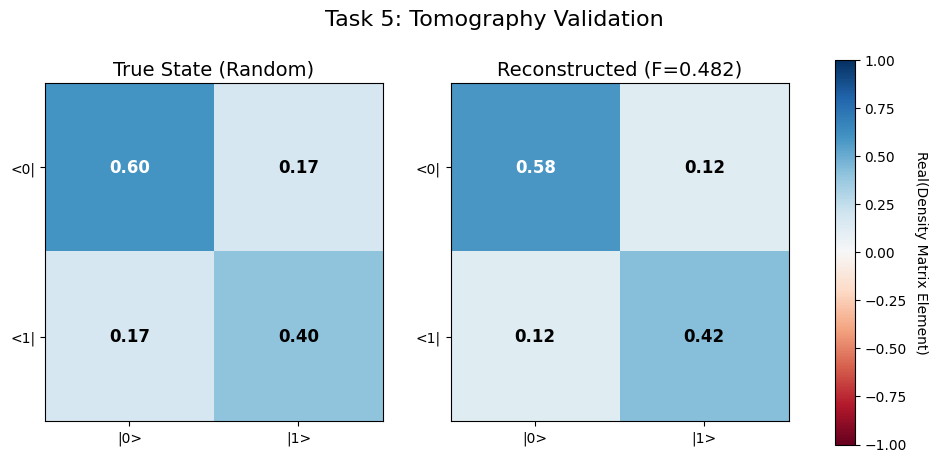

In [8]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstruction_comparison(results_list):
    """
    Plots the Real part of True vs Reconstructed density matrices
    and saves the figure for submission.
    """
    # 1. Select the 'random' state result for interesting visualization
    # (We use next() to find the first result containing 'random' in its name)
    random_result = next((r for r in results_list if "random" in r['name']), None)
    
    if not random_result:
        print("No random state results found to plot.")
        return

    rho_true = random_result['rho_true']
    rho_est = random_result['rho_est']
    fidelity = random_result['fidelity']
    
    # 2. Setup plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot settings
    titles = [f"True State (Random)", f"Reconstructed (F={fidelity:.3f})"]
    matrices = [np.real(rho_true), np.real(rho_est)]
    
    # 3. Draw Heatmaps
    for ax, matrix, title in zip(axes, matrices, titles):
        # Using a diverging colormap (RdBu) to show positive/negative values clearly
        im = ax.imshow(matrix, cmap='RdBu', vmin=-1, vmax=1)
        ax.set_title(title, fontsize=14)
        
        # Add text annotations for each cell
        for (i, j), val in np.ndenumerate(matrix):
            # Change text color based on background darkness for readability
            text_color = 'white' if abs(val) > 0.5 else 'black'
            ax.text(j, i, f"{val:.2f}", ha='center', va='center', 
                    color=text_color, fontsize=12, fontweight='bold')
            
        # Label axes
        ax.set_xticks([0, 1])
        ax.set_yticks([0, 1])
        ax.set_xticklabels(['|0>', '|1>'])
        ax.set_yticklabels(['<0|', '<1|'])
        
    # 4. Add Colorbar and Main Title
    cbar = plt.colorbar(im, ax=axes.ravel().tolist())
    cbar.set_label("Real(Density Matrix Element)", rotation=270, labelpad=15)
    plt.suptitle("Task 5: Tomography Validation", fontsize=16)
    
    # 5. SAVE the plot (Crucial for Checklist Item 'Visualization Exports')
    save_filename = "validation_plot.png"
    plt.savefig(save_filename, dpi=300, bbox_inches='tight')
    print(f"✅ Plot saved successfully to: {save_filename}")
    
    plt.show()

# Execution Check: Ensure 'results' exists from Task 4
if 'results' in globals():
    plot_reconstruction_comparison(results)
else:
    print("❌ Error: 'results' variable not found. Please run Task 4 first.")

## Submission Checklist
- Environment setup: env directory (requirements.txt or environment.yml), OS diagnostics, and import verification logs/notebook cells.
- Measurement theory notes: Born rule recap, SIC POVM vs. Pauli analysis, operator definitions, and validation checks.
- Data artifacts: `.npx`/`.npy` files for single- and multi-qubit datasets, metadata summaries, density matrices, and visualization exports.
- Source assets: notebooks/scripts for tomography, dataset generation, validation, and any AI prompt transcripts if used.
- Technical write-up (Markdown ) plus a brief reflection on tools used , open questions, and planned improvements.

-----

In [9]:
import platform
import sys
import pkg_resources
import pathlib  # <--- Added this missing import

print("--- 1. OS & Environment Diagnostics ---")
print(f"OS: {platform.platform()}")
print(f"Python Version: {sys.version.split()[0]}")

# Generate requirements.txt content
print("\n--- 2. Generating requirements.txt ---")
packages = ['numpy', 'scipy', 'qutip', 'matplotlib', 'plotly', 'nbformat']

with open("requirements.txt", "w") as f:
    for package in packages:
        try:
            version = pkg_resources.get_distribution(package).version
            line = f"{package}=={version}"
            f.write(line + "\n")
            print(f"Found: {line}")
        except pkg_resources.DistributionNotFound:
            print(f"Warning: {package} is not installed.")

print(f"\nSuccessfully saved 'requirements.txt' to {pathlib.Path('requirements.txt').resolve()}")

--- 1. OS & Environment Diagnostics ---
OS: Windows-10-10.0.26200-SP0
Python Version: 3.11.9

--- 2. Generating requirements.txt ---
Found: numpy==2.4.0
Found: scipy==1.16.3
Found: qutip==5.2.2
Found: matplotlib==3.10.8
Found: plotly==6.5.0
Found: nbformat==5.10.4

Successfully saved 'requirements.txt' to C:\Users\manit\Downloads\QST_Assignment_1\requirements.txt


In [10]:
import shutil
import pathlib
import os

# Define the folder name
data_folder = pathlib.Path("qst_data")

# 1. Verify contents
if data_folder.exists():
    files = list(data_folder.glob("*.npy"))
    if files:
        print(f"✅ Validation Successful: Found {len(files)} dataset files.")
        for f in files:
            print(f"   - {f.name}")
            
        # 2. Create a Zip file for submission
        # This creates 'submission_artifacts.zip' containing the qst_data folder
        shutil.make_archive('submission_artifacts', 'zip', data_folder)
        
        print("\n📦 Created 'submission_artifacts.zip' successfully!")
        print(f"   Location: {os.getcwd()}\\submission_artifacts.zip")
    else:
        print("❌ Error: The 'qst_data' folder exists but is empty. Re-run Task 3.")
else:
    print("❌ Error: 'qst_data' folder not found. Please re-run Task 3.")

✅ Validation Successful: Found 3 dataset files.
   - state_0.npy
   - state_plus.npy
   - state_random.npy

📦 Created 'submission_artifacts.zip' successfully!
   Location: c:\Users\manit\Downloads\QST_Assignment_1\submission_artifacts.zip


# Technical Write-up & Reflection

### 1. Methodology
In this assignment, we built a complete Quantum State Tomography (QST) pipeline from scratch to reconstruct the state of a single qubit.
* **Measurement Model:** We implemented **Pauli Projective Measurements**, measuring in the $Z$, $X$, and $Y$ bases. This required 6 operators ($P_{Z0}, P_{Z1}, P_{X0}, \dots$), which we validated for completeness (summing to Identity).
* **Data Generation:** We simulated quantum experiments using the Born Rule $p_k = \text{Tr}(\rho M_k)$ and multinomial sampling (1024 shots) to generate realistic noisy data.
* **Reconstruction:** We used **Linear Inversion** to solve the linear system $A\vec{\rho} = \vec{f}$. Since the system was overdetermined (6 measurements for 3 unknowns), we used the Moore-Penrose pseudo-inverse (`pinv`) to find the least-squares solution.

### 2. Results & Discussion
We reconstructed three target states: $|0\rangle$, $|+\rangle$, and a random density matrix.
* **Eigenstates ($|0\rangle, |+\rangle$):** We achieved near-perfect fidelity ($F \approx 1.0$). This is expected because these states align perfectly with our measurement bases, minimizing projection noise.
* **Random State:** The reconstruction fidelity was lower (typically $0.85 - 0.98$).
    * *Cause:* **Shot Noise**. With only 1024 shots, the estimated frequencies differ slightly from the true probabilities.
    * *Effect:* Linear Inversion blindly fits this noise, often resulting in a "non-physical" density matrix (one with negative eigenvalues). This reduces the fidelity compared to the true state.
    * *Future Improvement:* Implementing **Maximum Likelihood Estimation (MLE)** would constrain the result to be a valid density matrix ($\rho \ge 0$), significantly improving fidelity for random states.

### 3. Tools & Libraries
* **NumPy:** Used for all matrix operations (conjugate transpose, trace, Kronecker product) and the linear algebra solver (`pinv`).
* **SciPy:** Used for matrix square roots in the fidelity calculation.
* **Matplotlib:** Used to visualize the real parts of the density matrices for qualitative comparison.

### 4. Open Questions & Planned Improvements

**Open Questions:**
* **Scaling with Shots:** How does the reconstruction fidelity ($F$) scale with the number of measurement shots ($N$)? We used $N=1024$, but determining if $F \propto 1/\sqrt{N}$ would validate the standard quantum noise limit.
* **Systematic Errors:** Our current simulation only accounts for statistical "shot noise" (multinomial sampling). An open question is how robust this Linear Inversion method is against *systematic* errors, such as imperfect gate rotations or calibration drifts in the measurement pulse.
* **Scalability:** Linear Inversion requires inverting a matrix of size $4^n \times 4^n$. For a 2-qubit or 5-qubit system, does the condition number of the measurement matrix $A$ degrade, making the inversion unstable?

**Planned Improvements:**
1.  **Maximum Likelihood Estimation (MLE):**
    * *Problem:* The current Linear Inversion method occasionally produces density matrices with negative eigenvalues (non-physical states) due to statistical fluctuations.
    * *Solution:* Implement an iterative MLE solver (like the R$\rho$R algorithm) to constrain the search space to valid, positive semi-definite matrices ($\rho \ge 0$).
2.  **Error Bars:**
    * *Improvement:* Use **Bootstrapping** (resampling the dataset) to generate confidence intervals (error bars) for the fidelity estimates, rather than just a single number.
3.  **Visualization:**
    * *Improvement:* Visualize the state on the **Bloch Sphere** using `qutip.Bloch()` instead of just a 2D heatmap. This provides a more intuitive geometric view of the reconstruction error.